In [2]:
# reload notebook
%load_ext autoreload
%autoreload 2
import jax 
import sys 
sys.path.append("/scr/aliang80/changepoint_aug/changepoint_aug/online_rl_training")
import pickle
import jax.numpy as jnp
import os
import haiku as hk
import matplotlib.animation as animation
from utils import load_maze_data, make_blob_dataset
import pickle
import jax
import torch
import haiku as hk
import numpy as np
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from models import q_fn, vae_fn, decode_fn
from functools import partial
from configs.q_config import get_config as get_q_config
from configs.vae_config import get_config as get_vae_config
from tensorflow_probability.substrates import jax as tfp

dist = tfp.distributions
os.environ['CUDA_VISIBLE_DEVICES'] = '7'


2024-02-27 01:41:20.442311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 01:41:20.442355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 01:41:20.443107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 01:41:21.091556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
dataset, train_loader, test_loader, obs_dim, action_dim = make_blob_dataset(
    10000,
    centers=6,
    n_features=4,
    random_state=0,
    train_perc=1.0,
    batch_size=32,
)

number of train batches:  312
number of test batches:  0


In [4]:
X = dataset[:][0].numpy()
y = dataset[:][1].numpy()
print(X.shape, y.shape)

(10000, 4) (10000,)


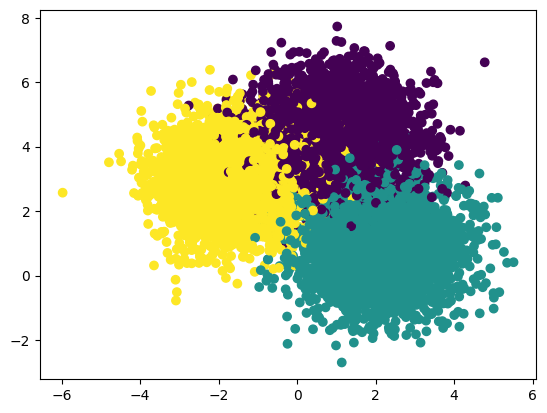

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y)

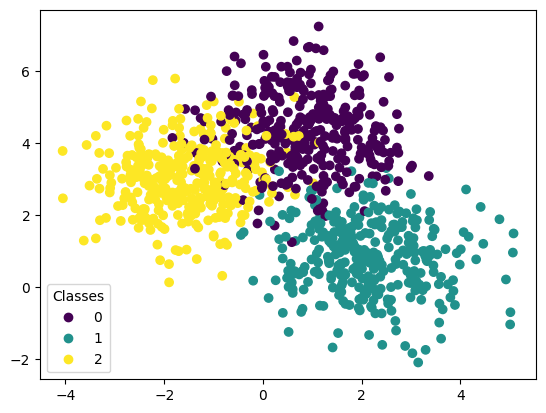

In [16]:
scatter=plt.scatter(X[:1000, 0], X[:1000, 1], c=y[:1000])
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

In [12]:
print(y)

[0 1 0 ... 1 1 0]


In [18]:
vae_config = get_vae_config()

# load vae density model
results_file = os.path.join(vae_config.results_dir, "vae_params_toy.pkl")
print(results_file)
with open(results_file, "rb") as f:
    vae_params = pickle.load(f)

apply_vae_fn = partial(vae_fn.apply, 
    latent_size=vae_config.latent_size,
    hidden_size=vae_config.hidden_size,
    obs_dim=2,
    cond_dim=1
)

apply_decode_fn = partial(hk.without_apply_rng(decode_fn).apply, 
    latent_size=vae_config.latent_size, 
    hidden_size=vae_config.hidden_size, 
    obs_dim=2, 
    cond_dim=1
)

def estimate_density(vae_params, rng_key, obs, goal, kl_div_weight, latent_size):
    vae_output = apply_vae_fn(vae_params, rng_key, obs, goal)

    # sample a bunch of z's from the posterior and decode them 
    # posterior is a normal distribution with mean and stddev
    z = dist.Normal(0, 1)
    num_posterior_samples = 200
    z_samples = z.sample(seed=rng_key, sample_shape=(num_posterior_samples, latent_size))

    # decode conditioned on goal  
    obs_pred = jax.vmap(lambda z: apply_decode_fn(vae_params, z, goal))(z_samples)

    # repeat obs for each z sample
    obs = jnp.repeat(obs[None], num_posterior_samples, axis=0)

    # compute average l2 loss
    recon_loss = optax.squared_error(obs_pred, obs).mean()

    prior = dist.Normal(0, 1)
    posterior = dist.Normal(loc=vae_output.mean, scale=vae_output.stddev)
    kl_div_loss = dist.kl_divergence(posterior, prior).mean()

    # we want to maximize elbo
    # elbo = E[log p(x|z)] - KL[q(z|x) || p(z)]
    loss = recon_loss + kl_div_weight * kl_div_loss
    elbo = -loss
    return elbo

/scr/aliang80/changepoint_aug/changepoint_aug/online_rl_training/model_ckpts/vae_params_toy.pkl


(1000,)
(1000,)
(1000,)


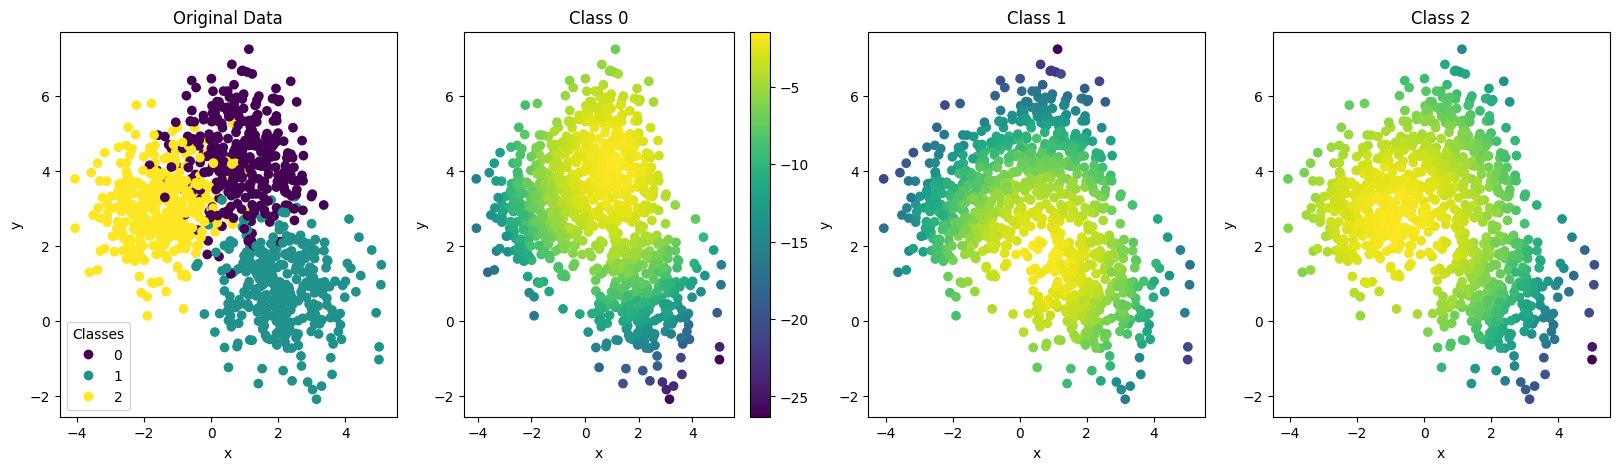

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()

scatter = axes[0].scatter(X[:1000, 0], X[:1000, 1], c=y[:1000])
axes[0].set_title("Original Data")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

for i in range(1, 4):
    cond = jnp.array([i-1])
    rng_key = jax.random.PRNGKey(0)
    rng_keys = jax.random.split(rng_key, 1000)
    density = jax.vmap(
        lambda obs, key: estimate_density(vae_params, key, obs, cond, vae_config.kl_div_weight, vae_config.latent_size)
    )(X[:1000], rng_keys)
    print(density.shape)
    scat = axes[i].scatter(X[:1000, 0], X[:1000, 1], c=density, cmap="viridis")
    axes[i].set_title(f"Class {i-1}")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")

fig.colorbar(scat, ax=axes[1])  